In [184]:
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

import skimage as ski

import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

try:
    from einops import rearrange
    from tqdm import tqdm
except:
    %pip install einops
    %pip install tqdm
    from einops import rearrange
    from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [19]:
def img_display(img):
    plt.imshow(rearrange(img, 'c h w -> h w c').cpu().detach().numpy())

In [3]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

--2024-09-20 14:20:58--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 18.65.229.20, 18.65.229.91, 18.65.229.55, ...
Connecting to segment-anything.com (segment-anything.com)|18.65.229.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.02s   

2024-09-20 14:20:58 (10.4 MB/s) - ‘dog.jpg’ saved [221810/221810]

torch.Size([3, 1365, 2048])


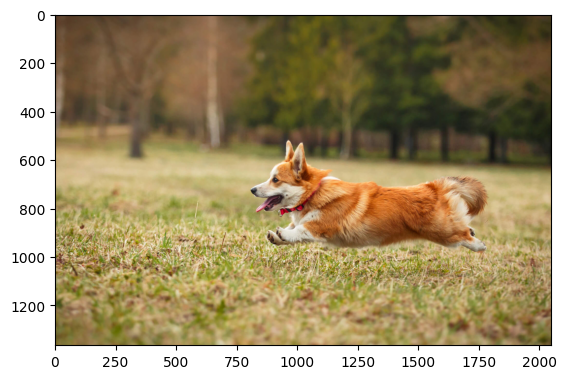

In [4]:
img_display(img)

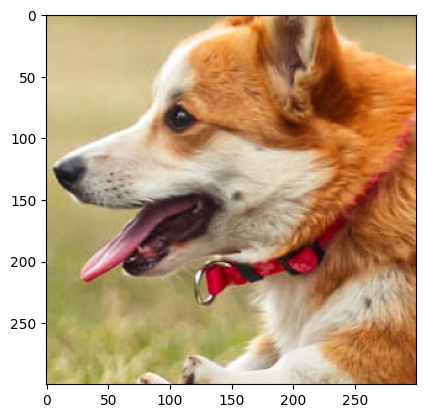

In [5]:
# Cropping the image
crop = torchvision.transforms.functional.crop(img.cpu(), 600, 800, 300, 300)
img_display(crop)

In [92]:
# Scaling image values
scaler = preprocessing.MinMaxScaler().fit(crop.reshape(-1, 1))
img_scaled = scaler.transform(crop.reshape(-1, 1)).reshape(crop.shape)
img_scaled = torch.tensor(img_scaled).to(device)

In [109]:
def mat_factorise(A, r, iter=10, device=torch.device("cpu")):
    print(device)
    A = A.to(device)

    # Random initialisation for factors
    W = torch.randn(A.shape[0], r, requires_grad=True, device=device)
    H = torch.randn(r, A.shape[1], requires_grad=True, device=device)

    optimiser = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)

    for _ in tqdm(range(iter)):

      # Calculating the loss
      diff_matrix = torch.mm(W, H) - A
      diff_vector = diff_matrix[mask]
      loss = torch.norm(diff_vector)

      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

    return torch.mm(W, H)

## Task 4

### Q1

In [114]:
def reconstruct_img(img, iter=5000):
    recon = torch.zeros(img.shape)

    for i in range(3):
        recon[i] = mat_factorise(img[i], 30, iter, device)

    return recon

In [115]:
img_recon = reconstruct_img(img_scaled)

cuda


100%|██████████| 5000/5000 [00:07<00:00, 676.69it/s]


cuda


100%|██████████| 5000/5000 [00:06<00:00, 790.96it/s]


cuda


100%|██████████| 5000/5000 [00:06<00:00, 752.24it/s]


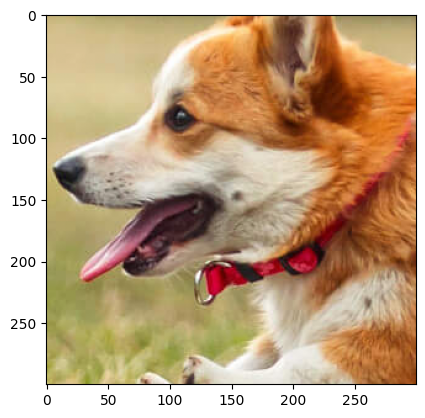

In [116]:
img_display(img_scaled)

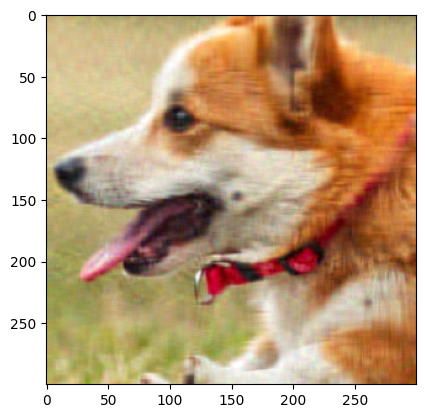

In [117]:
img_display(img_recon)

In [118]:
def metrics(img_scaled, img_recon, cpu=False):
  if cpu:
    truth = img_scaled.cpu().detach().numpy()
    predicted = img_recon.cpu().detach().numpy()
  else:
    truth = img_scaled.detach().numpy()
    predicted = img_recon.detach().numpy()
  rmse = np.sqrt(ski.metrics.mean_squared_error(truth, predicted))
  peak_snr = ski.metrics.peak_signal_noise_ratio(truth, predicted)

  print("RMSE:", rmse)
  print("Peak SNR:", peak_snr)

In [119]:
metrics(img_scaled, img_recon, cpu=True)

RMSE: 0.032094592282190984
Peak SNR: 29.871362741216956


<ipython-input-118-d15b6afa6ef7>:9: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  peak_snr = ski.metrics.peak_signal_noise_ratio(truth, predicted)


## Q2

In [120]:
def remove_rand_pixel(img):
    clone = img.clone()
    n, m = img.shape[1], img.shape[2]

    mask = np.zeros(n*m)
    mask[np.random.choice(n*m, size=900)] = 1
    mask = np.reshape(mask, (n , m))

    clone = clone.cpu().numpy()
    clone[:, mask==1] = float('nan')

    return torch.from_numpy(clone)

In [121]:
fault_img = remove_rand_pixel(img_scaled)

In [122]:
recon_img = reconstruct_img(fault_img)

cuda


100%|██████████| 5000/5000 [00:06<00:00, 802.66it/s]


cuda


100%|██████████| 5000/5000 [00:06<00:00, 756.59it/s]


cuda


100%|██████████| 5000/5000 [00:06<00:00, 791.99it/s]


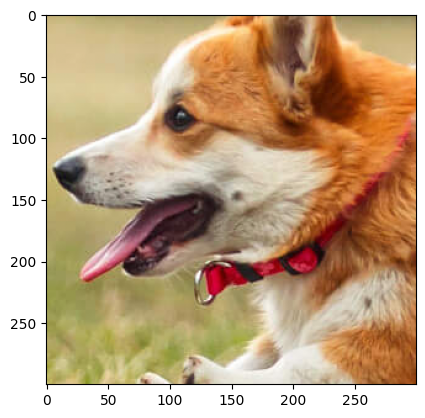

In [123]:
img_display(img_scaled)

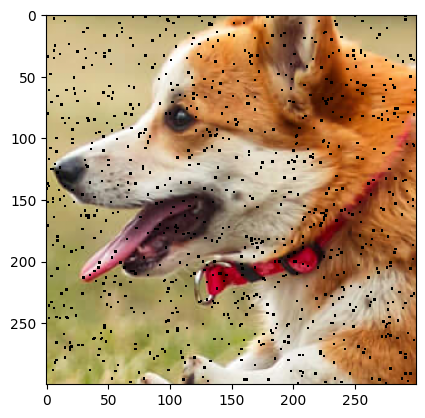

In [124]:
img_display(fault_img)

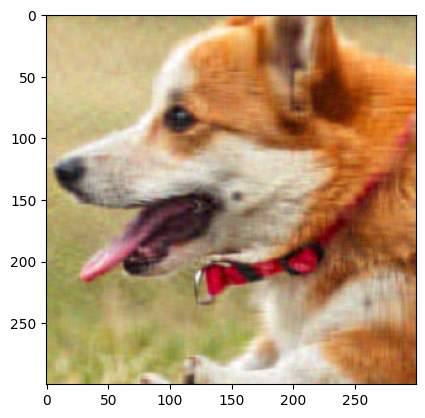

In [125]:
img_display(recon_img)

In [129]:
truth = fault_img.cpu().detach().numpy()
predicted = recon_img.cpu().detach().numpy()
truth = np.nan_to_num(truth, nan=0.5)
predicted = np.nan_to_num(predicted, nan=0.5)
rmse = np.sqrt(ski.metrics.mean_squared_error(truth, predicted))
peak_snr = ski.metrics.peak_signal_noise_ratio(truth, predicted)

print("RMSE:", rmse)
print("Peak SNR:", peak_snr)

RMSE: 0.040187499285698675
Peak SNR: 27.91818034901894


<ipython-input-129-eb9452466ace>:6: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  peak_snr = ski.metrics.peak_signal_noise_ratio(truth, predicted)


### Comparison with RFF and Linear Regression

In [151]:
def create_coordinate_map(img, scale = 1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Scale the dimensions of the image
    height = int(height * scale)
    width = int(width * scale)

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> h w c').float()
    return X, Y

In [145]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [146]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [140]:
def create_rff_features(X, num_features, sigma):
    """
    X: torch.Tensor of shape (num_samples, 2)
    num_features: int
    sigma: float
    """
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=1)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device), rff

In [147]:
import gc
gc.collect()

46824

In [165]:
fault_img.shape


torch.Size([3, 300, 300])

In [167]:
fault_img1 = torch.nan_to_num(fault_img)
fault_img1

tensor([[[0.7686, 0.7686, 0.7686,  ..., 0.5451, 0.5451, 0.5412],
         [0.7725, 0.7725, 0.7725,  ..., 0.5686, 0.5686, 0.5647],
         [0.7765, 0.7765, 0.7765,  ..., 0.5882, 0.5843, 0.5843],
         ...,
         [0.7961, 0.7373, 0.7176,  ..., 0.5843, 0.5725, 0.5490],
         [0.8471, 0.7843, 0.7451,  ..., 0.6039, 0.5686, 0.5569],
         [0.8784, 0.8196, 0.7686,  ..., 0.6275, 0.5804, 0.5686]],

        [[0.6941, 0.6941, 0.6941,  ..., 0.5137, 0.5137, 0.5098],
         [0.6980, 0.6980, 0.6980,  ..., 0.5255, 0.5255, 0.5216],
         [0.7020, 0.7020, 0.7020,  ..., 0.5451, 0.5412, 0.5412],
         ...,
         [0.7686, 0.7098, 0.6863,  ..., 0.2824, 0.2706, 0.2431],
         [0.8157, 0.7569, 0.7137,  ..., 0.3059, 0.2667, 0.2431],
         [0.8431, 0.7882, 0.7333,  ..., 0.3294, 0.2706, 0.2588]],

        [[0.4745, 0.4745, 0.4745,  ..., 0.3294, 0.3294, 0.3255],
         [0.4784, 0.4784, 0.4784,  ..., 0.3451, 0.3451, 0.3412],
         [0.4824, 0.4824, 0.4824,  ..., 0.3647, 0.3608, 0.

In [168]:

X_, Y_ = create_coordinate_map(fault_img1)

# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_.cpu())

# Scale the X coordinates
X_scaled = scaler_X.transform(X_.cpu())

# Move the scaled X coordinates to the GPU
X_scaled = torch.tensor(X_scaled).to(device)

# Set to dtype float32
X_scaled = X_scaled.float()

In [169]:
X_scaled.shape

torch.Size([90000, 2])

In [171]:
X_rff, rff = create_rff_features(X_scaled, 15000, 0.008)
X_rff.shape

torch.Size([90000, 15000])

In [172]:
Y_ = Y_.view(-1, 3)  # Shape becomes (90000, 3)
Y_.shape

torch.Size([90000, 3])

In [173]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.02, X_rff.to(device), Y_.to(device), 2500)

Epoch 0 loss: 0.365284
Epoch 100 loss: 0.015507
Epoch 200 loss: 0.010323
Epoch 300 loss: 0.007618
Epoch 400 loss: 0.006003
Epoch 500 loss: 0.005021
Epoch 600 loss: 0.004432
Epoch 700 loss: 0.004084
Epoch 800 loss: 0.003882
Epoch 900 loss: 0.003765
Epoch 1000 loss: 0.003696
Epoch 1100 loss: 0.003654
Epoch 1200 loss: 0.003628
Epoch 1300 loss: 0.003610
Epoch 1400 loss: 0.003598
Epoch 1500 loss: 0.003588
Epoch 1600 loss: 0.003582
Epoch 1700 loss: 0.003576
Epoch 1800 loss: 0.003572
Epoch 1900 loss: 0.003568
Epoch 2000 loss: 0.003565
Epoch 2100 loss: 0.003563
Epoch 2200 loss: 0.003561
Epoch 2300 loss: 0.003559
Epoch 2400 loss: 0.003558


0.003556464333087206

In [174]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")

    fig.suptitle(title, y=0.9)
    plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


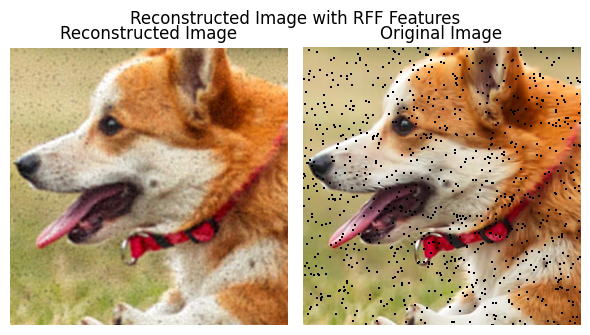

In [177]:
 plot_reconstructed_and_original_image(fault_img, net, X_rff, title="Reconstructed Image with RFF Features")

In [179]:
# Handle CUDA memory issues
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.empty_cache()

net.half()

# EnsureX_transformed is on the right device
X_transformed = torch.tensor(rff.transform(X_scaled.cpu().numpy()), dtype=torch.float16).to(device)

# Model inference and moving predictions to the appropriate device
X_pred = net(X_transformed).to(device)

# Ensure the predicted output can be reshaped to the same shape as 'fault_img'
X_pred_reshaped = X_pred.reshape(fault_img.shape).to(device)

# Ensure 'fault_img' is on the same device (usually GPU)
fault_img = fault_img.to(device)

# Check the shapes of 'fault_img' and 'X_pred_reshaped'
fault_img.shape, X_pred_reshaped.shape

(torch.Size([3, 300, 300]), torch.Size([3, 300, 300]))

In [180]:
# Normalize the predicted image tensor to [0, 1]
def normalize_0_1(tensor):
    min_val = tensor.min()
    max_val = tensor.max()
    # Apply min-max normalization
    tensor_normalized = (tensor - min_val) / (max_val - min_val)
    return tensor_normalized

# Normalize the predicted image
X_pred_normalized = normalize_0_1(X_pred_reshaped)

# Check the minimum and maximum values after normalization
print(f"Min value: {X_pred_normalized.min().item():.6f}")
print(f"Max value: {X_pred_normalized.max().item():.6f}")

Min value: 0.000000
Max value: 1.000000


In [181]:
def psnr(original, reconstructed):
    mse = mean_squared_error(original, reconstructed)
    if mse == 0:  # Means no noise in the image
        return 100
    pixel_max = 1.0  # Assuming pixel values are normalized between 0 and 1
    return 20 * np.log10(pixel_max / np.sqrt(mse))

In [188]:
fault_img1=fault_img1.cpu()
X_pred_normalized=X_pred_normalized.cpu()

# Define MSE
mse_loss = nn.MSELoss()

# Compute MSE
mse = mse_loss(X_pred_normalized, fault_img1)

# Compute PSNR
psnr_value = psnr(fault_img1.cpu().flatten().detach().numpy(), X_pred_normalized.cpu().flatten().detach().numpy())

print(f"RMSE: {mse.item()**0.5:.6f}")
print(f"PSNR: {psnr_value:.6f} dB")

RMSE: 0.315429
PSNR: 10.021957 dB


# Task 5


In [136]:
def data_compression(img, x_start, y_start, n=50, r=30, title=''):
    # n = patch size
    duplicate_img = img.clone()
    trimmed_img = torchvision.transforms.functional.crop(img.cpu(), x_start, y_start, n, n)

    recon_img = trimmed_img.clone()
    for i in range(3):
        recon_img[i] = mat_factorise(trimmed_img[i], r, 1000, device)

    x_end, y_end = x_start + n, y_start + n
    duplicate_img[:, x_start:x_end, y_start:y_end] = recon_img

    fig, ax = plt.subplots(2, 2, figsize=(7, 7))
    fig.suptitle(title)
    ax[0, 0].imshow(rearrange(img, 'c h w -> h w c').cpu().detach().numpy())
    ax[0, 0].set_title("Initial image")
    ax[0, 1].imshow(rearrange(trimmed_img, 'c h w -> h w c').cpu().detach().numpy())
    ax[0, 1].set_title("Image Patch")
    ax[1, 0].imshow(rearrange(recon_img, 'c h w -> h w c').cpu().detach().numpy())
    ax[1, 0].set_title("Compressed Patch")
    ax[1, 1].imshow(rearrange(duplicate_img, 'c h w -> h w c').cpu().detach().numpy())
    ax[1, 1].set_title("Reconstructed Img (with patch)")

    truth = trimmed_img.cpu().detach().numpy()
    predicted = recon_img.cpu().detach().numpy()
    truth = np.nan_to_num(truth, nan=0.5)
    predicted = np.nan_to_num(predicted, nan=0.5)
    rmse = np.sqrt(ski.metrics.mean_squared_error(truth, predicted))
    peak_snr = ski.metrics.peak_signal_noise_ratio(truth, predicted)

    print("RMSE:", rmse)
    print("Peak SNR:", peak_snr)

cuda


100%|██████████| 1000/1000 [00:01<00:00, 806.11it/s]


cuda


100%|██████████| 1000/1000 [00:01<00:00, 729.90it/s]


cuda


100%|██████████| 1000/1000 [00:01<00:00, 661.13it/s]


RMSE: 0.006255303334099821
Peak SNR: 44.07503251035743
cuda


100%|██████████| 1000/1000 [00:01<00:00, 815.72it/s]


cuda


100%|██████████| 1000/1000 [00:01<00:00, 817.74it/s]


cuda


100%|██████████| 1000/1000 [00:01<00:00, 775.20it/s]


RMSE: 0.004223257487636186
Peak SNR: 47.48704878565982
cuda


100%|██████████| 1000/1000 [00:01<00:00, 799.86it/s]


cuda


100%|██████████| 1000/1000 [00:01<00:00, 792.39it/s]


cuda


100%|██████████| 1000/1000 [00:01<00:00, 815.50it/s]


RMSE: 0.004317234628606642
Peak SNR: 47.295886962291874
cuda


100%|██████████| 1000/1000 [00:01<00:00, 812.72it/s]


cuda


100%|██████████| 1000/1000 [00:01<00:00, 749.11it/s]


cuda


100%|██████████| 1000/1000 [00:01<00:00, 660.46it/s]


RMSE: 0.004693222102422492
Peak SNR: 46.57057785427949
cuda


100%|██████████| 1000/1000 [00:01<00:00, 818.93it/s]


cuda


100%|██████████| 1000/1000 [00:01<00:00, 807.19it/s]


cuda


100%|██████████| 1000/1000 [00:01<00:00, 813.58it/s]


RMSE: 0.005118510186040406
Peak SNR: 45.81712856225836
cuda


100%|██████████| 1000/1000 [00:01<00:00, 844.32it/s]


cuda


100%|██████████| 1000/1000 [00:01<00:00, 830.72it/s]


cuda


100%|██████████| 1000/1000 [00:01<00:00, 823.15it/s]


RMSE: 0.005367316141213492
Peak SNR: 45.40485647010827
cuda


100%|██████████| 1000/1000 [00:01<00:00, 822.22it/s]


cuda


100%|██████████| 1000/1000 [00:01<00:00, 830.51it/s]


cuda


100%|██████████| 1000/1000 [00:01<00:00, 685.25it/s]


RMSE: 0.005584199539339929
Peak SNR: 45.06078143059923
cuda


100%|██████████| 1000/1000 [00:01<00:00, 713.74it/s]


cuda


100%|██████████| 1000/1000 [00:01<00:00, 802.19it/s]


cuda


100%|██████████| 1000/1000 [00:01<00:00, 804.49it/s]


RMSE: 0.006631331540301449
Peak SNR: 43.56798517083833


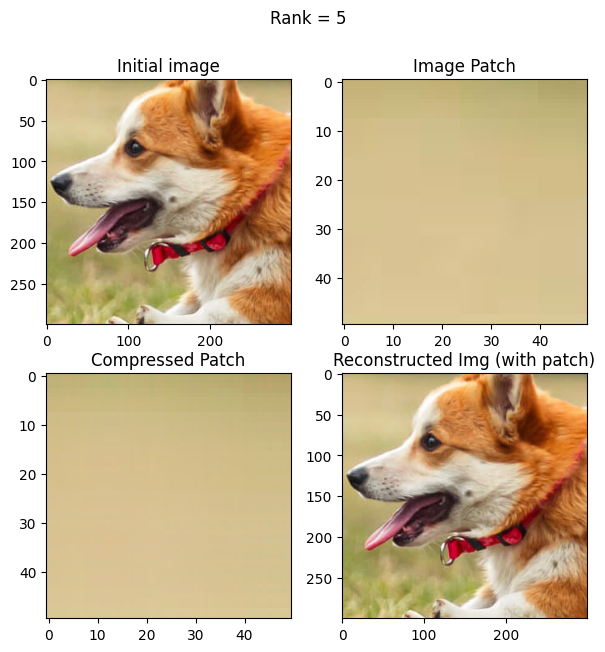

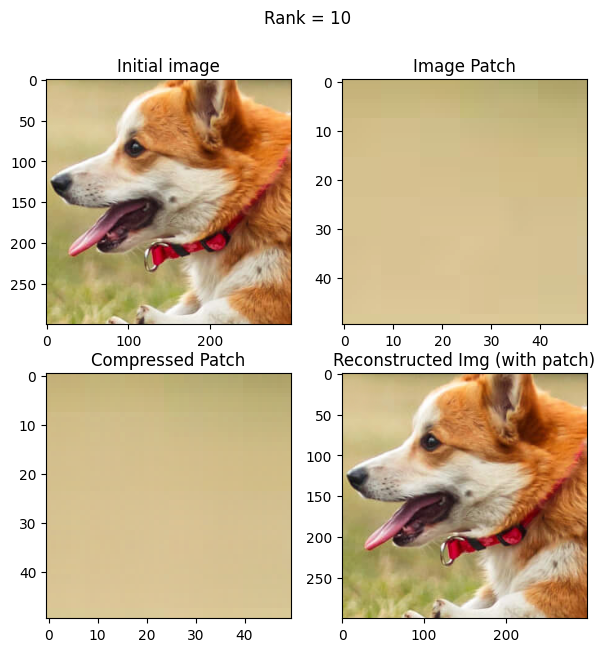

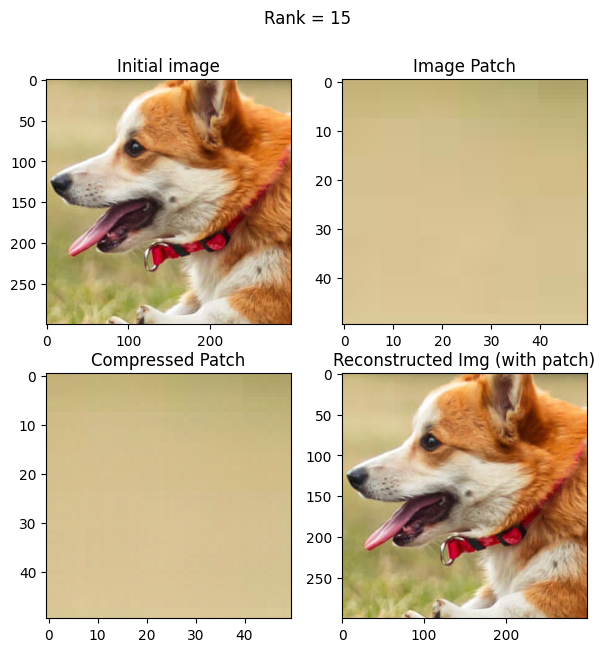

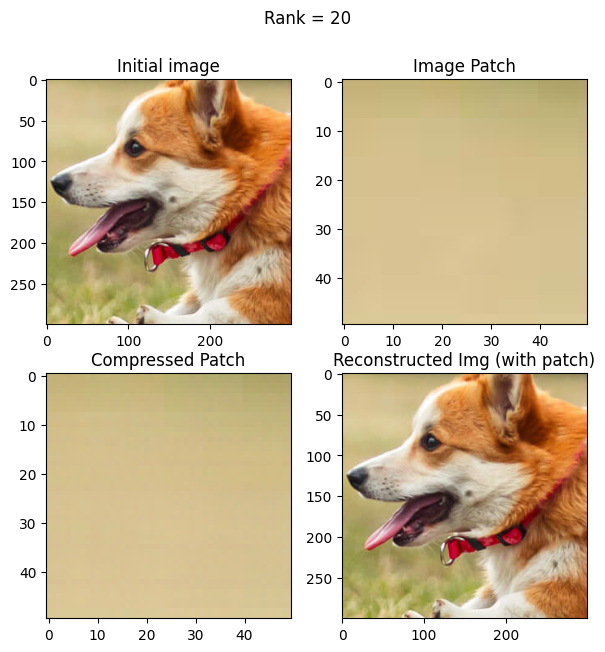

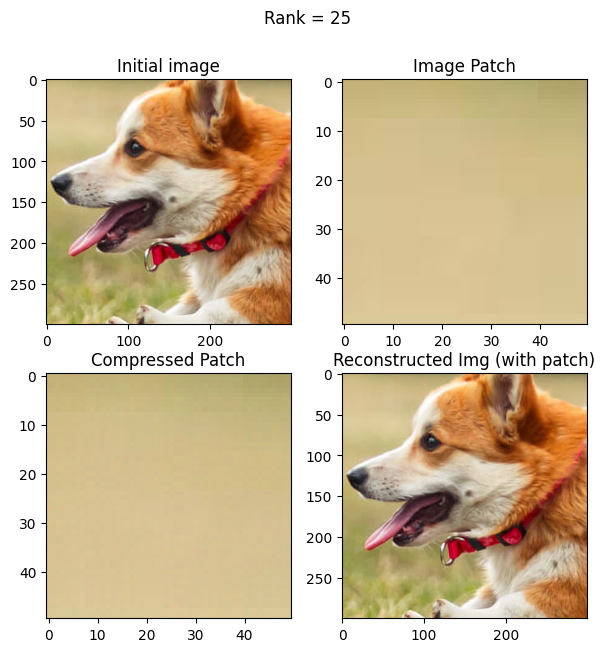

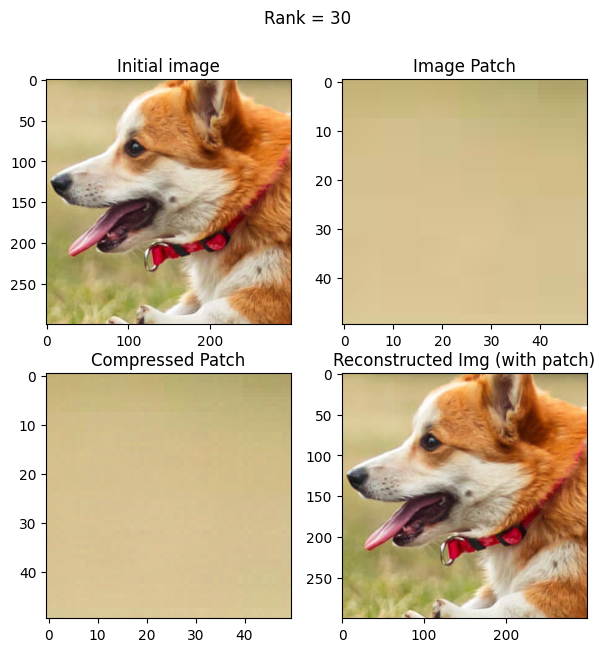

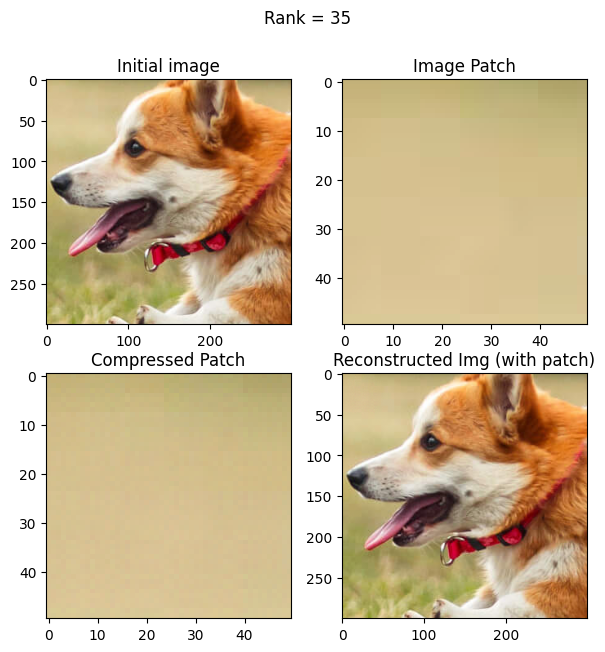

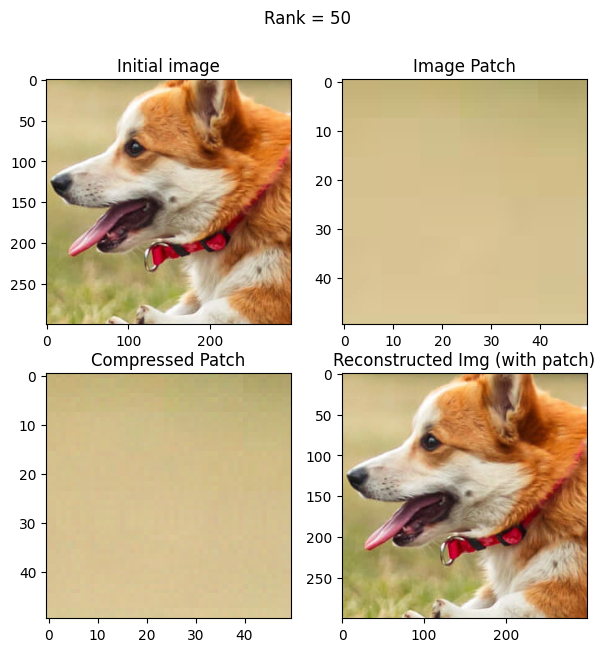

In [190]:
r_values = [5, 10, 15, 20, 25, 30, 35, 50]
for r in r_values:
  data_compression(img_scaled, 0, 0, 50, r, f'Rank = {r}')